Import Part

In [11]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot
from scipy import stats
from pandas import DataFrame

Const

In [12]:
FILES_FOLDER_PATH = 'files_cambridgeshire_bedfordshire'
FILE_NAME = 'cambridgeshire_bedfordshire.csv'

Functions

In [13]:
def remove_outliers(df: DataFrame):
    Q1 = np.percentile(df['wqi'], 25,
                   interpolation = 'midpoint')
 
    Q3 = np.percentile(df['wqi'], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1

    ''' Removing the Outliers '''
    df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df

Loading dataset

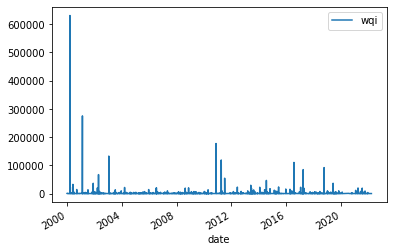

In [14]:
df = pd.read_csv(os.path.join(FILES_FOLDER_PATH, FILE_NAME), usecols=['date', 'wqi'], header=0, index_col=0)
df.index = pd.to_datetime(df.index)
df = df.sort_values('date', ascending=True)
df.plot()
pyplot.show()

Removing outliers

In [15]:
df = remove_outliers(df)

Showing trend

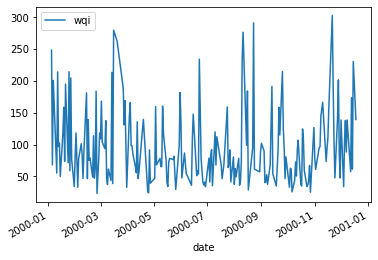

In [16]:
df_2000 = df.loc['2000-01-01' : '2000-12-31']
df_2000.plot()
pyplot.show()

Train/test split

Observations: 4452
Training Observations: 3561
Testing Observations: 891


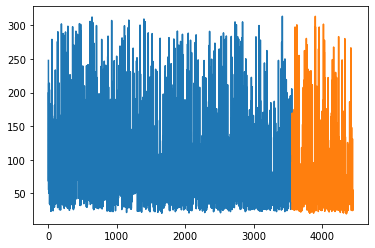

In [17]:
X = df.values
train_size = int(len(X) * 0.8)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

pyplot.plot(train)
pyplot.plot(np.asanyarray([None for i in train] + [x for x in test], dtype=object))
pyplot.show()

Loading full dataset

In [18]:
df = pd.read_csv(os.path.join(FILES_FOLDER_PATH, FILE_NAME), header=0, index_col=0)
df.index = pd.to_datetime(df.index)
df = df.sort_values('date', ascending=True)

Sliding window

In [19]:
STEP = 1 # fixed step for now
values = DataFrame(df.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.index = df.index
len(dataframe.columns)
# dataframe.columns = [ f"{col} (t-1)" for col in df.columns ] + [ f"{col} (t-2)" for col in df.columns[:-1]] + ['y']
dataframe.columns = [ f"x{i}" for i in range(1, len(df.columns) * 2)] + ["y"]
dataframe = dataframe.dropna()
dataframe

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x13,x14,x15,x16,x17,x18,x19,x20,x21,y
date,,,,,,,,,,,,,,,,,,,,,
2000-01-06,5.34,0.54,10.40,1.73,540.00,7.95,5.38,10.62,1219.09,1.67,...,0.13,11.20,1.43,596.67,7.97,3.79,11.50,990.82,1.00,68.00
2000-01-07,8.02,0.13,11.20,1.43,596.67,7.97,3.79,11.50,990.82,1.00,...,0.41,8.50,2.00,335.00,8.12,16.97,12.06,1722.86,0.67,200.36
2000-01-10,5.43,0.41,8.50,2.00,335.00,8.12,16.97,12.06,1722.86,0.67,...,0.94,14.10,6.33,335.00,7.93,5.32,10.61,973.22,1.00,423.83
2000-01-11,5.33,0.94,14.10,6.33,335.00,7.93,5.32,10.61,973.22,1.00,...,0.10,12.03,1.02,245.00,8.08,4.55,11.64,910.70,0.98,55.27
2000-01-12,6.51,0.10,12.03,1.02,245.00,8.08,4.55,11.64,910.70,0.98,...,0.46,11.10,1.02,90.00,8.24,6.06,10.90,1473.75,2.33,213.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-18,8.40,0.27,17.90,2.00,335.00,8.15,6.05,11.30,820.00,0.67,...,0.27,13.35,2.00,335.00,8.11,6.05,11.33,836.33,0.67,131.00
2022-03-21,7.73,0.27,13.35,2.00,335.00,8.11,6.05,11.33,836.33,0.67,...,0.03,7.38,2.00,335.00,7.98,6.05,9.96,879.28,0.67,24.43
2022-03-22,6.20,0.03,7.38,2.00,335.00,7.98,6.05,9.96,879.28,0.67,...,0.10,9.53,2.00,335.00,7.98,6.05,9.96,879.28,0.67,55.47


Training model

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [21]:
mean_error = []
X = dataframe.values
train_max_index = int(len(X) * 0.8)
val_max_index = int(len(X) * 0.9)
max_index = len(X)
for index in range(train_max_index, val_max_index - 1):
    train, val = X[0:  index], X[index : index + 1]

    X_train, X_test = train[:, :-1], val[:, :-1]
    Y_train, Y_test = train[:, -1], val[:, -1]

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=23)
    mdl.fit(X_train, Y_train)

    p = mdl.predict(X_test)

    error = mean_squared_error(Y_test, p)
    date = dataframe.iloc[[index]].index.tolist()[0]
    print('Date %s - Error %.5f' % (date, error))
    mean_error.append(error)
print('Mean error = %.5f' % np.mean(mean_error))
    


Date 2017-01-05 00:00:00 - Error 0.00613
Date 2017-01-09 00:00:00 - Error 0.26325
Date 2017-01-10 00:00:00 - Error 0.00000
Date 2017-01-11 00:00:00 - Error 0.02238
Date 2017-01-12 00:00:00 - Error 0.01539
Date 2017-01-13 00:00:00 - Error 0.23525
Date 2017-01-16 00:00:00 - Error 0.75172
Date 2017-01-17 00:00:00 - Error 0.23127
Date 2017-01-18 00:00:00 - Error 0.01175
Date 2017-01-19 00:00:00 - Error 0.03627
Date 2017-01-21 00:00:00 - Error 0.16783
Date 2017-01-22 00:00:00 - Error 16847.89462


KeyboardInterrupt: 